In [2]:
import torch
import torch.nn as nn

In [3]:
!pip install lightning

In [4]:
import lightning as L

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

In [6]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [7]:
from torch.utils.data.dataset import random_split
torch.manual_seed(1337)

train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [8]:
len(train_dataset), len(val_dataset)

(55000, 5000)

In [9]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

In [10]:
# ?DataLoader

In [11]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print("Training label distributions")
print(sorted(train_counter.items()))

val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

print("Validation label distributions")
print(sorted(val_counter.items()))

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("Test label distributions")
print(sorted(test_counter.items()))



Training label distributions
[(0, 5423), (1, 6214), (2, 5459), (3, 5633), (4, 5342), (5, 5005), (6, 5406), (7, 5723), (8, 5352), (9, 5443)]
Validation label distributions
[(0, 500), (1, 528), (2, 499), (3, 498), (4, 500), (5, 416), (6, 512), (7, 542), (8, 499), (9, 506)]
Test label distributions
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


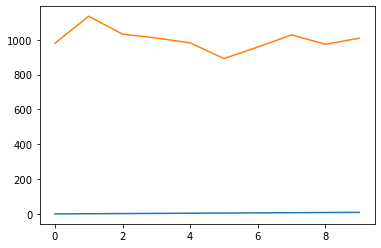

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(sorted(test_counter.items()))

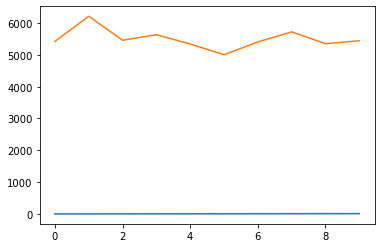

In [13]:
plt.plot(sorted(train_counter.items()))

In [14]:
majority_class = test_counter.most_common(1)[0]
print(majority_class)

(1, 1135)


In [15]:
baseline_acc = majority_class[1] / sum(test_counter.values())
print(baseline_acc)

0.1135


In [16]:
import numpy as np
import torchvision

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [17]:
images[:64].shape

torch.Size([64, 1, 28, 28])

torch.Size([251, 251, 3])


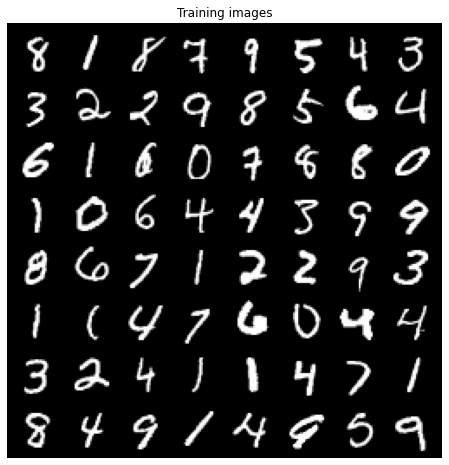

In [18]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
a = torchvision.utils.make_grid(
    images,
    padding=3,
    normalize=True
)
b = np.transpose(a, (1, 2, 0))
print(b.shape)
plt.imshow(b)
plt.show()

In [19]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.all_layers = nn.Sequential(
            nn.Linear(num_features, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, num_classes),
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [20]:
a = torch.randn(64, 1, 28, 28)
print(torch.flatten(a, start_dim=1).shape)
print(a.flatten(start_dim=1).shape)

torch.Size([64, 784])
torch.Size([64, 784])


In [21]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device = torch.device("cpu")

    correct = 0.0
    total_examples = 0.0

    for idx, (features, labels) in enumerate(dataloader):
        features, labels = features.to(device), labels.to(device)
        # TODO: should we put model on device, it should aleady be added to device during training.

        with torch.no_grad():
            logits = model(features)
            print(logits.shape) # [B, num_classes]
        
        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += predictions.shape[0]
    
    return correct / total_examples


In [22]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        features, labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, labels)
        # self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        features, labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, labels)
        # self.log("validation_loss", loss, prog_bar=True)
    
    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), learning_rate=self.learning_rate)
        return optim



In [23]:
len(train_loader), len(val_loader), len(test_loader)

(860, 79, 157)

In [24]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
pytorch_model

PyTorchMLP(
  (all_layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=10, bias=True)
  )
)

In [25]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [26]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(
        model=lightning_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
)

: 

: 